*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# A Day At the Track


TODO: Introduction

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/track.ipynb).

In [1]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate, plot_vector, plot_vectors, scatter, trajectory

In [4]:
from utils import set_precision

set_precision(4)

## Vector Addition and Subtraction

Let's start with the basics of adding and subtracting vectors -- then we'll see an example where these operations are useful.
We'll use NumPy arrays to store the Cartesian coordinates of two vectors.

In [5]:
A = np.array([1.1, 0.2])
B = np.array([0.1, 0.9])

To add vectors in this representation, we add the coordinates elementwise -- and since that's what array addition does, we can perform vector addition like this.

In [6]:
C = A + B
C

array([1.2, 1.1])

We can think of a vector as a point in the Cartesian plane, so we can draw `A`, `B`, and `C` like this.

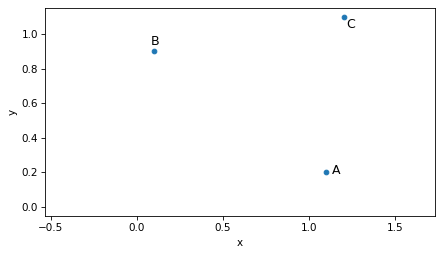

In [78]:
scatter([A, B, C], s=20)
plot_vector(A, label='A', alpha=0)
plot_vector(B, label='B', alpha=0)
plot_vector(C, label='C', label_pos=1, alpha=0, color='C1')
plt.axis('equal')
decorate(xlabel='x', ylabel='y')

It is also common to represent vectors as arrows with their tails at the origin.

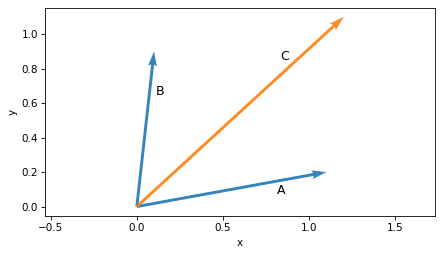

In [59]:
plot_vector(A, label='A', label_pos=2)
plot_vector(B, label='B', label_pos=2)
plot_vector(C, label='C', label_pos=10, color='C1')
plt.axis('equal')
decorate(xlabel='x', ylabel='y')

But it's not necessary to put the tail at the origin.
For example, we could put the tail of `B` at the head of `A`.

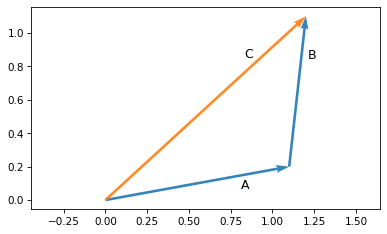

In [9]:
plot_vector(A, label='A', label_pos=2)
plot_vector(C, label='C', label_pos=10, color='C1')
plot_vector(B, origin=A, label='B', label_pos=2)
plt.axis('equal')
decorate(xlabel='x', ylabel='y')

In this arrangement we can see that adding vectors is like lining them up head to tail.
If we start from the origin and follow `A`, then continue from `A` and follow `B`, we arrive at their sum, `C`.

To compute the difference between two vectors, we subtract the coordinates elementwise.

In [10]:
D = B - A
D

array([-1. ,  0.7])

If we plot the result, `D`, with its tail at `A`, we get a graphical representation of subtraction.
And if we follow the arrows, we can see the inverse operation -- the sum of `A` and `D` is `B`.

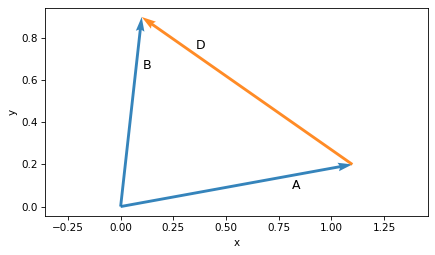

In [60]:
plot_vector(A, label='A', label_pos=2)
plot_vector(B, label='B', label_pos=2)
plot_vector(D, origin=A, label='D', label_pos=2, color='C1')
plt.axis('equal')
decorate(xlabel='x', ylabel='y')

These examples show three ways to represent a vector: a point in Cartesian coordinates, an arrow with its tail at the origin, or an arrow at any other location.
They also show the graphical representation of vector addition and subtraction.

Now we'll use these vector operations to do work with GPS data.

## GPS Data

To prepare for this chapter, I went for a short run wearing a watch that tracked my location using the Global Positioning System (GPS).
I downloaded the results as a GPX file, which is a standard format for storing GPS tracks.

We'll use `load_gpx` to parse the file and extract the data.

In [67]:
import gpxpy

def load_gpx(filename):
    """Load a GPX file and return a DataFrame with lat, lon, elevation, and time."""
    with open(filename, "r") as f:
        gpx = gpxpy.parse(f)

    records = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                records.append({
                    "time": point.time,
                    "latitude": point.latitude,
                    "longitude": point.longitude,
                    "elevation": point.elevation,
                })

    return pd.DataFrame(records)

In [69]:
df_all = load_gpx("oval_run.gpx")
df_all.head()

,time,latitude,longitude,elevation
0,2025-11-16 16:08:09+00:00,42.2934,-71.2637,59.2000
1,2025-11-16 16:08:10+00:00,42.2935,-71.2637,59.2000
2,2025-11-16 16:08:11+00:00,42.2935,-71.2637,59.2000
3,2025-11-16 16:08:17+00:00,42.2936,-71.2637,59.3000
4,2025-11-16 16:08:18+00:00,42.2936,-71.2637,59.3000


The result is a Pandas `DataFrame` with one row for each measurement and columns for time, latitude and longitude in degrees, and elevation in meters above sea level. 

For this example, we'll select a segment of the run starting from the 34th measurement.

In [14]:
df = df_all.iloc[34:].reset_index(drop=True)

To visualize the data, we'll select an array of latitude-longitude pairs.

In [70]:
cols = ['latitude', 'longitude']
latlon = df[cols].values

Then we can use the `trajectory` function to plot it as a set of points in the plane -- with `fliplr` to flip the latitude and longitude columns so they correspond to x-y coordinates.

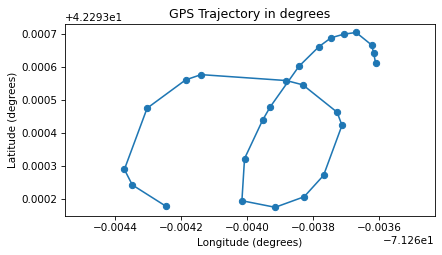

In [79]:
trajectory(np.fliplr(latlon), marker='o')

plt.axis("equal")
decorate(xlabel='Longitude (degrees)', ylabel='Latitude (degrees)', 
         title='GPS Trajectory in degrees')

If you are curious, you can probably figure out where I ran.

Working with latitude and longitude has some drawbacks: the units are in degrees rather than meters, and the relationship between these coordinates and actual distances depends on where you are on Earth.
But with a little geometry, we can convert latitude and longitude to distances in meters.

## Distances

To approximate the distance between two points on the surface of the earth, we'll convert each latitude-longitude pair to a 3D vector with its tail at the center of the earth, then compute the length of the difference between vectors.

As an example, let's extract the start and end points from the GPS trajectory.

In [82]:
start = latlon[0]
start

array([ 42.2936, -71.2636])

In [83]:
end = latlon[-1]
end

array([ 42.2932, -71.2642])

The key is to think of latitude and longitude as spherical coordinates, where longitude is the azimuth angle, measured in the plane of the equator from the reference point where longitude is 0, and latitude is the elevation angle, measured from the plane of the equator toward the poles.

The following figure shows how that works for the starting location of my run.

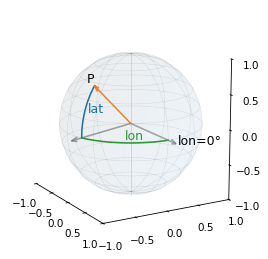

In [138]:
from utils import draw_arc_3D, setup_3D, plot_vector_3D, draw_globe, sph2cart, normalize

def spherical_coords_diagram(lat, lon, R=1):
    fig, [ax] = setup_3D(show_grid=False)
    ax.view_init(elev=15, azim=-30, roll=0)

    draw_globe(ax, R, alpha=0.1)

    # Draw the reference point
    point = sph2cart(np.deg2rad(lon), np.deg2rad(lat), R)
    plot_vector_3D(point, color='C1')
    ax.text(*point * 1.1, 'P', fontsize=12, ha='center')

    # Draw reference vectors
    ref_lon0 = np.array([R, 0, 0])  # lon=0° on equator
    plot_vector_3D(ref_lon0, scale=1.2, color='gray', alpha=0.7)
    ax.text(*ref_lon0 * 1.25, 'lon=0°', fontsize=12)
    
    ref_equator = normalize([point[0], point[1], 0])
    plot_vector_3D(ref_equator, scale=1.2, color='gray', alpha=0.7)

    # Draw longitude arc in equatorial plane
    draw_arc_3D([0, 0, 0], ref_lon0, ref_equator, radius=1, color='C2')
    mid_lon = (ref_lon0 + ref_equator) / 2
    ax.text(*mid_lon, 'lon', fontsize=12, color='C2')
    
    # Draw latitude arc from equator to point
    draw_arc_3D([0, 0, 0], ref_equator, point, radius=1, color='C0')
    point_norm = point / np.linalg.norm(point)
    mid_lat = (ref_equator + point_norm) / 2
    ax.text(*mid_lat, 'lat', fontsize=12, color='C0')

    lim = [-R, R]
    decorate(xlim=lim, ylim=lim, zlim=lim, aspect='equal')

spherical_coords_diagram(*start)

So we can use `sph2cart` to convert latitude and longitude to Cartesian coordinates -- we just have to convert from degrees to radians.

In [84]:
from utils import sph2cart

def latlon_to_cartesian(latlon, radius=1.0):
    lat, lon = latlon.T
    result = sph2cart(np.deg2rad(lon), np.deg2rad(lat), radius)
    return result

Now we can convert our start and end points to vectors, using the average radius of the earth in meters.

In [85]:
r_earth = 6_371_000
start_vec = latlon_to_cartesian(start, r_earth)
start_vec

array([ 1513777.2923, -4462926.6972,  4287237.4095])

In [86]:
end_vec = latlon_to_cartesian(end, r_earth)
end_vec

array([ 1513738.0516, -4462974.3777,  4287201.6299])

Here's the difference between the vectors.

In [139]:
diff = end_vec - start_vec
diff

array([-39.2407, -47.6805, -35.7796])

The distance between the points is the length of this difference vectors.

In [143]:
distance = norm(diff)
distance

71.3683

It's about 71 meters.

This calculation is based on the approximation that the earth is a sphere, so the radius is the same everywhere.
In fact, the earth is closer to an ellipsoid where the semi-axis from the center of the earth to the poles is about 6,357 km and the semi-axis from the center to the equator is about 6,378 km, a difference of about 0.3 percent.

It is also based on the approximation that the distance between two points on the surface is a straight line, not an arc.
For distances as small as the ones in this example, the difference is very small. 
To check, we can use the haversine function, which computes great-circle distance between two points.

In [141]:
from haversine import haversine, Unit

haversine_distance = haversine(start, end, unit=Unit.METERS)
haversine_distance

71.3684

The straight line approximation is off by 0.0001%, so it is negligible compared to the spherical approximation.

In [145]:
(distance - haversine_distance) / haversine_distance * 100

-0.0001

Let's encapsulate the straight-line approximation in a function.

In [147]:
def distance_between(start, end, r_earth=6_371_000):
    start_vec = latlon_to_cartesian(start, r_earth)
    end_vec = latlon_to_cartesian(end, r_earth)
    return norm(end_vec - start_vec)

Now we have everything we need to convert from latitude-longitude pairs to distances in meters.

## Converting Coordinates

To start, we'll compute the mean of the lat-lon pairs.

In [148]:
latlon_mean = latlon.mean(axis=0)
latlon_mean

array([ 42.2935, -71.2639])

Now we can compute the offset of each point from the center, multiplying by 1000 so the results are in millidegrees.

In [149]:
latlon_offset = (latlon - latlon_mean) * 1000
latlon_offset[:5]

array([[0.1458, 0.3005],
       [0.1758, 0.2945],
       [0.1998, 0.2885],
       [0.2378, 0.2415],
       [0.2328, 0.2045]])

To convert them to meters, we need to know how many meters correspond to one millidegree of latitude and longitude at our location.

We can use `distance_between` to compute this.

First, we'll create a vector that represents a location offset from `latlon_mean` by one millidegree in the direction of positive latitude, which is north.
Then we'll compute the distance between `latlon_mean` and this offset point.

In [165]:
north = [0.001, 0]
meters_north = distance_between(latlon_mean, latlon_mean+north)
meters_north

111.1949

Next we'll do the same thing with a point offset by one millidegree in the direction of positive longitude, which is east.

In [171]:
east = latlon_mean + [0, 0.001]
meters_east = distance_between(latlon_mean, east)
meters_east

82.2518

These distances tell us the number of meters per millidegree at this location.
We'll put these conversion factors in an array we'll use as a scaling vector.

In [174]:
scale = np.array([meters_north, meters_east])
scale

array([111.1949,  82.2518])

If we multiply the offsets in millidegrees by this scaling factor, the results are offsets in meters.

In [176]:
latlon_meters = latlon_offset * scale
latlon_meters[:5]

array([[16.2167, 24.715 ],
       [19.5525, 24.2215],
       [22.2212, 23.728 ],
       [26.4466, 19.8622],
       [25.8906, 16.8188]])

As the last step, we have to reverse the order of the columns -- because latitude corresponds to the `x` coordinate and longitude corresponds to the `y` coordinate.

In [177]:
position = np.fliplr(latlon_meters)
position[:5]

array([[24.715 , 16.2167],
       [24.2215, 19.5525],
       [23.728 , 22.2212],
       [19.8622, 26.4466],
       [16.8188, 25.8906]])

Let's plot the result.

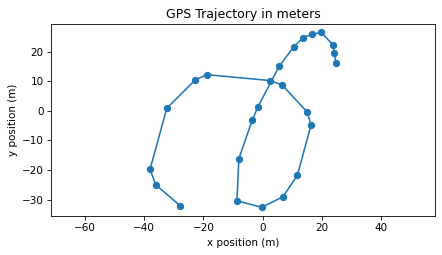

In [178]:
trajectory(position, 'o-')
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)",
         title="GPS Trajectory in meters")

After all that, the trajectory in meters doesn't look very different from the trajectory in degrees of longitude and latitude.
But now that it is expressed in meters, we'll use it to compute velocity and acceleration.

## Position and Velocity

At this point we have a sequence of vectors that represent offsets from a central point.
So far we have visualized these vectors as points in space, but we can also visualize them as arrows with their tails at the origin, like this.

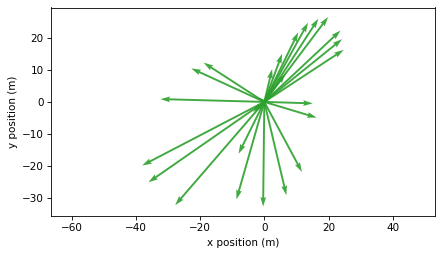

In [36]:
plot_vectors(position, color="C2", width=0.005)
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

If we compute the difference between each successive pair of vectors, the result is a sequence of vectors that represent offsets between successive locations.

In [193]:
diffs = np.diff(position, axis=0)

If we plot these differences with their tails at the corresponding locations, we can see that  the results trace the trajectory between points.

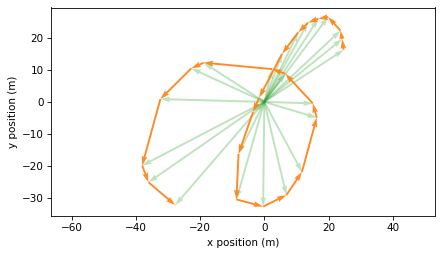

In [194]:
plot_vectors(position, color="C2", width=0.005, alpha=0.3)
plot_vectors(diffs, position[:-1], color="C1", width=0.005)
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

These differences represent offsets between successive measurements.
So we can compute the total distance I ran by computing the lengths of these vectors and adding them up.

In [201]:
from utils import norm

total_distance = norm(diffs, axis=1).sum()
total_distance

220.8934

We can compute the elapsed time by adding up the `dts`.

In [202]:
ts = dts[1:].cumsum()
elapsed_time = ts[-1]
elapsed_time

55.0000

And we can compute my average speed.

In [203]:
total_distance / elapsed_time

4.0162

My average speed was about 4 meters per second.
For comparison, the world record time for 200 meters is 19.19 seconds (set by Usain Bolt in 2009)

To convert them to velocities, we have to divide through by the time between measurements.
We can us `diff` to compute the difference between timestamps, and `total_seconds` to convert the differences to seconds.

In [185]:
dts = df["time"].diff().dt.total_seconds().values
dts

array([nan,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  4.,  1.,  3.,  4.,  3.,
        2.,  2.,  4.,  1.,  3.,  1.,  5.,  1.,  3.,  6.,  1.,  2.])

The time between measurements is usually one second, but sometimes longer. 
We can compute velocity by dividing position differences by time differences.

In [186]:
velocity = diffs / dts[1:, None]
velocity.shape

(24, 2)

The results are in meters per second.
The following figure shows these velocity vectors with their tails at the corresponding positions.

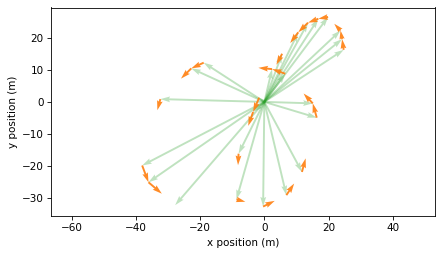

In [187]:
plot_vectors(position, color="C2", width=0.005, alpha=0.3)
plot_vectors(velocity, position[:-1], color="C1", width=0.005)
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

The magnitude of each velocity vector is the speed, which we can compute using the `norm` of each vector.

In [188]:
from utils import norm

speeds = norm(velocity, axis=1)
speeds.shape

(24,)

Let's plot the speed over time.

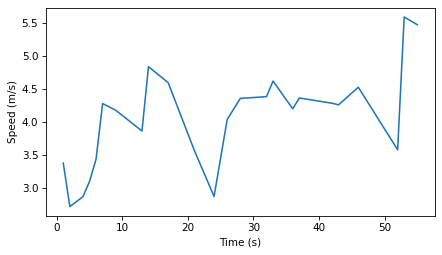

In [190]:
plt.plot(ts, speeds)
decorate(xlabel="Time (s)", ylabel="Speed (m/s)")

The results are noisy because the measurements are noisy -- and taking the difference between successive measurement tends to amplify the noise.
Nevertheless, it looks like my average speed was about 4 meters per second.

In [191]:
speeds.mean()

4.0525

For comparison, 

## From Velocity to Acceleration

Acceleration is the rate of change of velocity.
We compute it the same way: differences between consecutive velocities divided by time intervals.

In [44]:
diffs2 = np.diff(velocity, axis=0)
diffs2.shape

(23, 2)

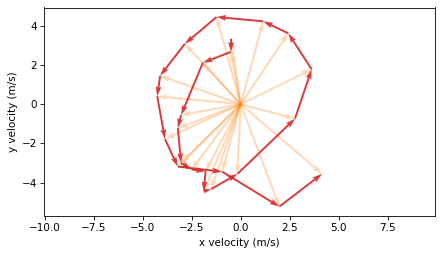

In [45]:
plot_vectors(velocity, color="C1", width=0.005, alpha=0.3)

plot_vectors(diffs2, velocity[:-1], width=0.005, color="C3")
plt.axis("equal")
decorate(xlabel="x velocity (m/s)", ylabel="y velocity (m/s)")

In [46]:
dt_velocity = (dts[1:-1] + dts[2:]) / 2
dt_velocity

array([1. , 1.5, 1.5, 1. , 1. , 1.5, 3. , 2.5, 2. , 3.5, 3.5, 2.5, 2. ,
       3. , 2.5, 2. , 2. , 3. , 3. , 2. , 4.5, 3.5, 1.5])

In [47]:
acc = norm(diffs2, axis=1)
acc

array([0.6672, 1.543 , 2.8905, 0.6872, 1.7867, 0.6302, 0.7245, 1.0337,
       0.3996, 1.5526, 4.0671, 2.6599, 2.1883, 1.414 , 2.3956, 2.1207,
       2.0616, 1.0557, 2.2149, 1.5546, 2.2767, 3.4192, 2.7446])

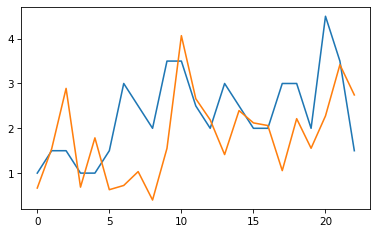

In [48]:
plt.plot(dt_velocity)
plt.plot(acc)

In [49]:
acceleration = diffs2 / dt_velocity[:, None]

We can plot acceleration vectors at their corresponding positions.
Note that we scale the acceleration by 10 to make it visible -- acceleration magnitudes are much smaller than velocities.

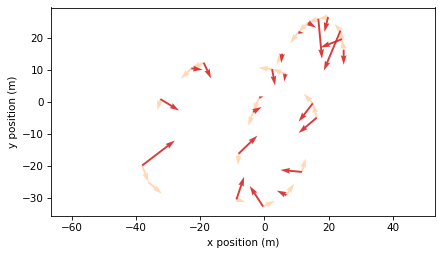

In [50]:
plot_vectors(velocity, position[:-1], color="C1", width=0.005, alpha=0.3)

plot_vectors(acceleration, position[:-2], scale=7, color="C3", width=0.005)
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

TODO: explain about the scaling and units, and also in the previous fig.

The acceleration vectors point toward the center of the curve, which is characteristic of **centripetal acceleration** -- the acceleration needed to make an object follow a curved path.

## Vector Integration

Suppose we had acceleration data from an accelerometer.
We can integrate acceleration to get velocity, and then integrate velocity to get position.
For each integration we need a starting value: the initial velocity for the first step and the initial position for the second.

First, integrate acceleration to reconstruct velocity.
We'll start with the measured initial velocity and add up the changes over time.

In [51]:
v0 = velocity[0]
dv = acceleration * dt_velocity[:, None]
velocity_from_acc = v0 + np.cumsum(dv, axis=0)
velocity_from_acc[:5]

array([[-0.4935,  2.6687],
       [-1.9329,  2.1127],
       [-3.0433, -0.556 ],
       [-3.2078, -1.2231],
       [-3.0433, -3.0023]])

Compare the reconstructed velocity to the measured one.
They should be close, but not identical because of noise and numerical error.

In [52]:
velocity[1:6]

array([[-0.4935,  2.6687],
       [-1.9329,  2.1127],
       [-3.0433, -0.556 ],
       [-3.2078, -1.2231],
       [-3.0433, -3.0023]])

Now integrate velocity to reconstruct position.
We'll start with the measured initial position and add up displacements over time.

In [53]:
x0 = position[0]
displacements = velocity * dts[1:, None]
position_from_vel = x0 + np.cumsum(displacements, axis=0)
position_from_vel[:5]

array([[24.2214, 19.5525],
       [23.7279, 22.2212],
       [19.8621, 26.4466],
       [16.8188, 25.8907],
       [13.611 , 24.6675]])

And compare with the measured positions.

In [54]:
position[1:6]

array([[24.2214, 19.5525],
       [23.7279, 22.2212],
       [19.8621, 26.4466],
       [16.8188, 25.8907],
       [13.611 , 24.6675]])

Now let's add a little measurement noise to acceleration and see what happens.
We'll repeat the two integrations and compare the trajectories.

In [55]:
rng = np.random.default_rng(1)
noise_scale = 0.1 * np.std(acceleration, axis=0)
acc_noisy = acceleration + rng.normal(scale=noise_scale, size=acceleration.shape)

velocity_noisy = v0 + np.cumsum(acc_noisy * dt_velocity[:, None], axis=0)
dt_position = dts[2:]
position_from_acc = position[1] + np.cumsum(velocity_from_acc * dt_position[:, None], axis=0)
position_noisy = position[1] + np.cumsum(velocity_noisy * dt_position[:, None], axis=0)

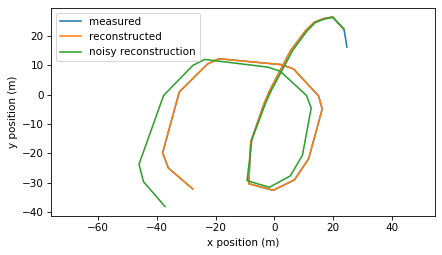

In [56]:
trajectory(position, label="measured")
trajectory(position_from_acc, label="reconstructed")
trajectory(position_noisy, label="noisy reconstruction")
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)